# DEEP LEARNING 

# Partie sur les images

### Objectif à dépasser : weighted F1-score = 0.5534 (Resnet)
avec CNN/Transfer learning

Import libraries:

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
os.chdir('C:\\Users\\barry\\OneDrive - CSTBGroup\\image_ds\\images')

In [2]:
from keras.applications.resnet50 import ResNet50
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator

Récupérer les données:

In [3]:
X = pd.read_csv('X_train_update.csv',index_col=0)
y = pd.read_csv('Y_train_CVw08PX.csv',index_col=0)

Liste des images:

In [4]:
os.chdir('C:\\Users\\barry\\OneDrive - CSTBGroup\\image_ds')

In [5]:
import os #Miscellaneous operating system interfaces
#https://docs.python.org/3/library/os.html

#get current working directory
current_path = os.getcwd() 

#Training images path
images_path = current_path + r'/images/image_train/'

#List with the name of all training images
images_list = os.listdir(images_path)

Géneration nom des images:

In [6]:
#Create a column with the name of the picture
X['image name'] = 'image_' + X['imageid'].map(str) + '_product_' + X['productid'].map(str) + '.jpg'
X['image name']

0        image_1263597046_product_3804725264.jpg
1         image_1008141237_product_436067568.jpg
2          image_938777978_product_201115110.jpg
3           image_457047496_product_50418756.jpg
4         image_1077757786_product_278535884.jpg
                          ...                   
84911      image_941495734_product_206719094.jpg
84912    image_1188462883_product_3065095706.jpg
84913     image_1009325617_product_440707564.jpg
84914    image_1267353403_product_3942400296.jpg
84915       image_684671297_product_57203227.jpg
Name: image name, Length: 84916, dtype: object

### Répartition des images dans les échantillons train, validation et test

Répartion :

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state = 123)

X_val = X_train.iloc[:1600,:]
y_val = y_train.iloc[:1600,:]

X_train = X_train.iloc[:14400,:]
y_train = y_train.iloc[:14400:,:]

X_test = X_test.iloc[:4000,:]
y_test = y_test.iloc[:4000,:]

Qualité de la répartitioon

trainy = pd.DataFrame(y_train.value_counts(), columns = ['Nombre_images_train'])
testy = pd.DataFrame(y_test.value_counts(), columns = ['Nombre_images_test'])
train_test = trainy.merge(testy, right_index = True, left_index = True)
train_test['y'] = train_test.index
yval = []
for i in train_test['y']:
    yval.append(i[0])
train_test['y'] = yval
train_test

In [12]:
X_train["class"] = y_train
X_test["class"] = y_test
X_val["class"] = y_val

# TRANSFER LEARNING

Image Generator :

In [13]:
# Creating objects for image augmentations


from keras.preprocessing.image import ImageDataGenerator

train_data_generator = ImageDataGenerator(rescale = 1./255,  
        rotation_range = 10,
        width_shift_range = 0.1,
        height_shift_range = 0.1,
        zoom_range = 1.1,
        horizontal_flip = True
        )

val_data_generator = ImageDataGenerator(rescale = 1./255,
        rotation_range = 10,
        width_shift_range = 0.1,
        height_shift_range = 0.1,
        zoom_range = 1.1,
        horizontal_flip = True
        )

test_data_generator = ImageDataGenerator(rescale = 1./255)

In [14]:
batch_size = 32
path = os.chdir('C:\\Users\\barry\\OneDrive - CSTBGroup\\image_ds\\images\\image_train')
X_train["class"] = X_train["class"].astype(str)
X_test["class"] = X_test["class"].astype(str)
X_val["class"] = X_val["class"].astype(str)

train_generator = train_data_generator.flow_from_dataframe(dataframe=X_train,
                                                          directory=path,
                                                           x_col = "image name",
                                                           y_col = "class",
                                                           class_mode ="sparse",
                                                          target_size = (224, 224), 
                                                          batch_size = batch_size)


val_generator = val_data_generator.flow_from_dataframe(dataframe=X_val,
                                                          directory=path,
                                                           x_col = "image name",
                                                           y_col = "class",
                                                           class_mode ="sparse",
                                                          target_size = (224, 224), 
                                                          batch_size = batch_size)

test_generator = test_data_generator.flow_from_dataframe(dataframe=X_test,
                                                          directory=path,
                                                           x_col = "image name",
                                                           y_col = "class",
                                                           class_mode ="sparse",
                                                          target_size = (224, 224), 
                                                          batch_size = batch_size, shuffle = False)

Found 14400 validated image filenames belonging to 27 classes.
Found 1600 validated image filenames belonging to 27 classes.
Found 4000 validated image filenames belonging to 27 classes.


Model creation :

In [26]:
from tensorflow.keras.optimizers import Adam


base_model = ResNet50(include_top=False, weights='imagenet')

# Taking the output of the last convolution block in ResNet50
x = base_model.output

# Adding a Global Average Pooling layer
x = GlobalAveragePooling2D()(x)

# Adding a fully connected layer having 1024 neurons
x = Dense(1024, activation='relu')(x)

# Adding a fully connected layer having 2 neurons which will
# give the probability of image having either dog or cat
predictions = Dense(27, activation='softmax')(x)

# Model to be trained
model = Model(inputs=base_model.input, outputs=predictions)

# Training only top layers i.e. the layers which we have added in the end
for layer in base_model.layers:
    layer.trainable = False

n_class = 27

    
# Compiling the model
model.compile(optimizer=Adam(lr=0.0001), loss='sparse_categorical_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

Training : 

In [27]:
# We will try to train the last stage of ResNet50


# Training the model for 10 epochs
model.fit_generator(train_generator, 
                                epochs = 4,
                                steps_per_epoch = len(X_train)//batch_size,
                                validation_data = val_generator,
                                validation_steps = len(X_val)//batch_size)


C:\Users\barry\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/4
450/450 [==============================] - 1348s 3s/step - loss: 3.1110 - accuracy: 0.1173 - val_loss: 3.0466 - val_accuracy: 0.1281
Epoch 2/4
450/450 [==============================] - 1322s 3s/step - loss: 3.0504 - accuracy: 0.1324 - val_loss: 3.0594 - val_accuracy: 0.0825
Epoch 3/4
450/450 [==============================] - 1327s 3s/step - loss: 3.0277 - accuracy: 0.1389 - val_loss: 3.0152 - val_accuracy: 0.1287
Epoch 4/4
450/450 [==============================] - 1030s 2s/step - loss: 3.0009 - accuracy: 0.1398 - val_loss: 2.9723 - val_accuracy: 0.1412


Entrainement 4 derniers layers freezed :

In [28]:
for layer in base_model.layers[-3:]:
    layer.trainable = True

In [29]:
model.compile(optimizer=Adam(lr=0.0001), loss='sparse_categorical_crossentropy', metrics = ['accuracy'])
tl_2_defreeze = model.fit_generator(generator=train_generator, 
                                epochs = 4,
                                steps_per_epoch = len(X_train)//batch_size,
                                validation_data=test_generator,
                                validation_steps=len(X_val)//batch_size
                                )

Epoch 1/4
450/450 [==============================] - 844s 2s/step - loss: 2.9872 - accuracy: 0.1546 - val_loss: 2.8313 - val_accuracy: 0.1875
Epoch 2/4
450/450 [==============================] - 834s 2s/step - loss: 2.9388 - accuracy: 0.1543 - val_loss: 2.8214 - val_accuracy: 0.1963
Epoch 3/4
450/450 [==============================] - 901s 2s/step - loss: 2.9303 - accuracy: 0.1589 - val_loss: 2.7876 - val_accuracy: 0.1975
Epoch 4/4
450/450 [==============================] - 929s 2s/step - loss: 2.9238 - accuracy: 0.1550 - val_loss: 2.7567 - val_accuracy: 0.2106


Analyse graphique (qualité du modèle :)

In [30]:
history = tl_2_defreeze

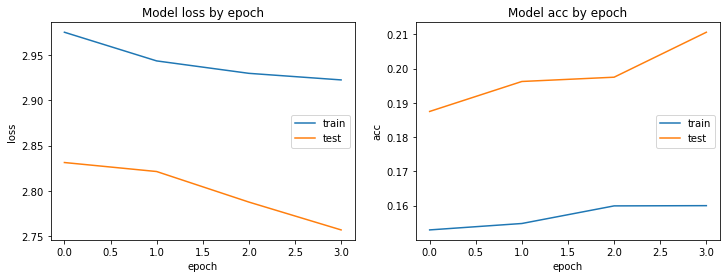

In [31]:
plt.figure(figsize=(12,4))

plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')

plt.subplot(122)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model acc by epoch')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')
plt.show()

Evaluation : 

In [32]:
y_tl_pred_2 = model.predict_generator(test_generator, verbose = 1)
y_tl_pred_2 = y_tl_pred_2.argmax(axis = 1)

C:\Users\barry\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


125/125 [==============================] - 225s 2s/step


In [33]:
from sklearn.metrics import f1_score
f1_score(test_generator.classes, y_tl_pred_2 , average = "weighted")

0.12449941200386246

In [60]:
from sklearn.metrics import confusion_matrix
print(pd.DataFrame(confusion_matrix( test_generator.classes, y_tl_pred_2)))

     0   1    2   3    4   5    6   7   8   9   ...  17   18  19   20  21  22  \
0   118   0    5   0    1   2    0   0   0   0  ...   0    4   2    1   0  20   
1     4  65    8   0   39   4    4   0   1  14  ...   1    0   0    8   0   0   
2     0   1  234   0    0   0    0   0   0   0  ...   1    1   0    0   0   1   
3     2  11    2   0    5   0    1   0   0   3  ...   1    2   0    2   0   2   
4     5  18    9   0  114   8   33   0  19  19  ...   3    9   0   16   0   3   
5     5   0   11   0   19  21    6   0   7   1  ...   0    9   0    3   0   0   
6     1   5    1   1    9   1  177   0  20  10  ...   6   11   1   51   0   0   
7     0   1    0   0    2   0    2   0   3  12  ...   0    8   0   10   0   1   
8     1   0    1   0   31   4   11   0  38  14  ...   0    5   6   19   1   0   
9     2   0    0   0   31   4    4   0   6  56  ...   0   10   1   21   1   1   
10    1   1    0   0   11   1    9   0   6  16  ...   1   14   2   21   1   0   
11    0   0    0   0    5   